In [1]:
from math import sqrt

import numpy as np

import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import skimage
from skimage import io, exposure, img_as_float, img_as_ubyte, morphology, filters, util
from skimage.color import rgb2gray, label2rgb
from skimage.feature import canny, blob_dog, blob_log, blob_doh,  peak_local_max
from skimage.filters import sobel, threshold_otsu, try_all_threshold, threshold_local, threshold_minimum
from skimage.segmentation import clear_border, watershed, random_walker
from skimage.measure import label, regionprops
from skimage.measure import label, regionprops
from skimage.color import label2rgb
from skimage.morphology import closing

import cv2

from scipy import ndimage as ndi
from scipy.stats import norm

import os

import plotly.graph_objs as go

### Read image

Read image as greyscale and color in parallel

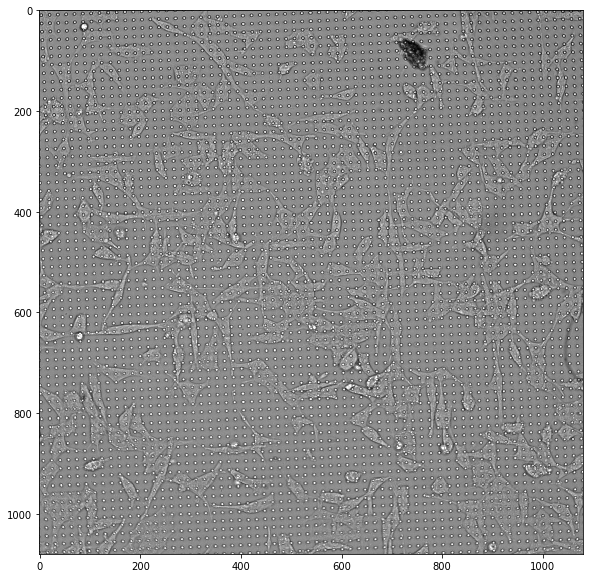

In [2]:
image_file = cv2.imread('/Users/carolinemccue/Desktop/MG63/r01c02f26p03-ch2sk1fk1fl1.tiff',0)
fig, ax = plt.subplots(figsize=(10,10))

plt.imshow(image_file, cmap=plt.cm.gray, interpolation='nearest')

plt.show()

### convert to uint (for some skimage methods)

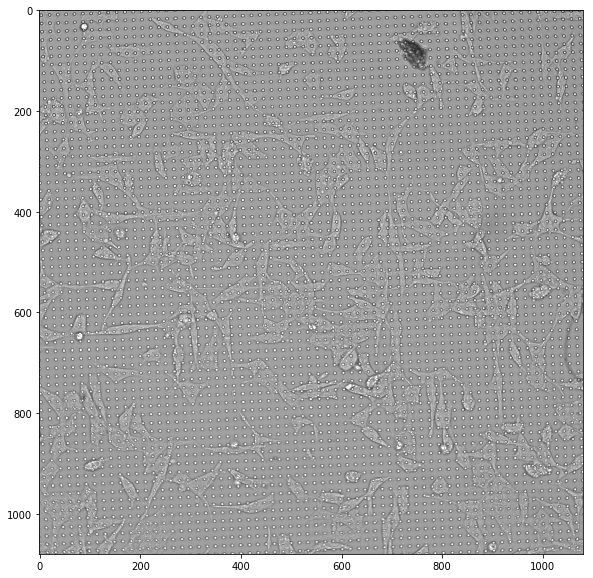

In [3]:
fig, ax = plt.subplots(figsize=(10,10))
plt.imshow(image_file, cmap=plt.cm.gray, vmin=0, vmax=255, interpolation='nearest')
plt.show()

### Increase contrast

Adaptive equalization can deal with some non-uniformity in the original image

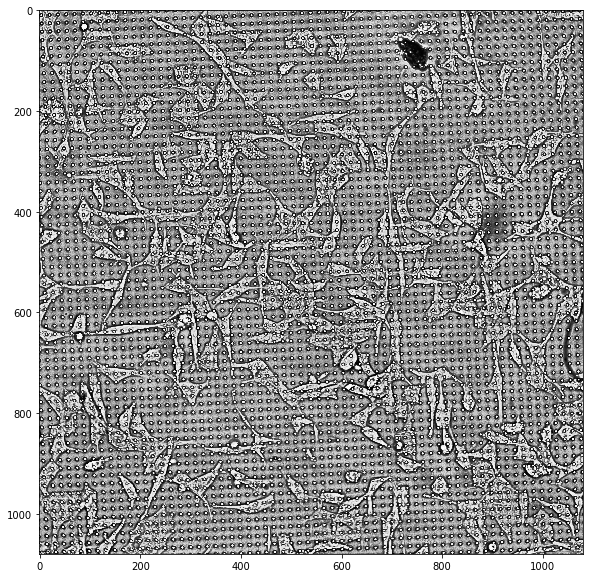

In [4]:
# Adaptive Equalization
clahe = cv2.createCLAHE(clipLimit=15, tileGridSize=(10,10))
img_adapteq = clahe.apply(image_file)
fig, ax = plt.subplots(figsize=(10,10))
plt.imshow(img_adapteq, cmap=plt.cm.gray, interpolation='nearest')
plt.show()

### Threshold

Otsu threshold was found to work best in this type of image (see SegmentationDropletsInCapillary).

Minimum threshold: 124.0
Min intensity: 0
Max intensity: 255


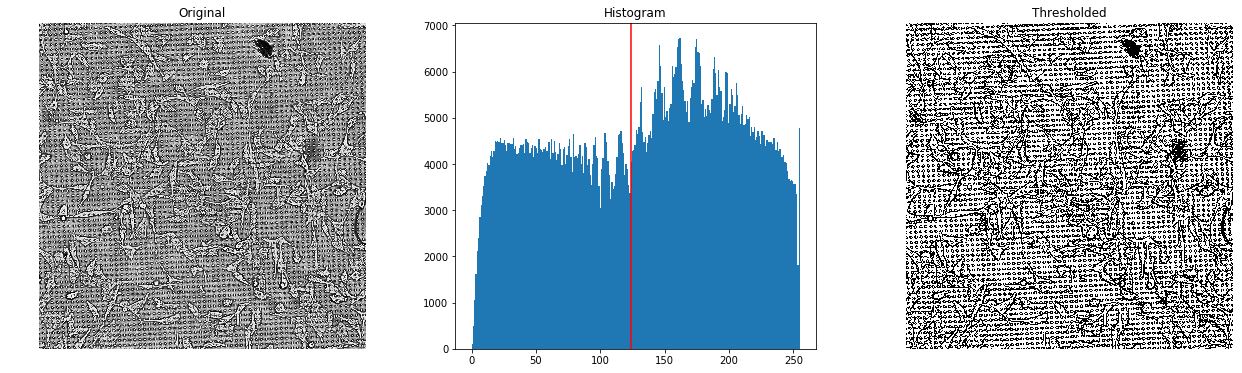

In [5]:
image = img_adapteq

blur = cv2.GaussianBlur(image,(3,3),0)
retVal, binary = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

fig, axes = plt.subplots(ncols=3, figsize=(22, 6))
ax = axes.ravel()
ax[0] = plt.subplot(1, 3, 1)
ax[1] = plt.subplot(1, 3, 2)
ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].hist(image.ravel(), bins=256)
ax[1].set_title('Histogram')
ax[1].axvline(retVal, color='r')

ax[2].imshow(binary, cmap=plt.cm.gray)
ax[2].set_title('Thresholded')
ax[2].axis('off')

print('Minimum threshold: ' + str(retVal))
print('Min intensity: ' + str(np.min(image)))
print('Max intensity: ' + str(np.max(image)))
plt.show()

### Perform Watershed segmentation

- Close to remove artifacts from contrast increase and thresholding
- Detect sure foreground and background from thresholding and distance transform
- Run the watershed algorithm to segment
- Label segmented regions

#### Closing and removing small dark spots from crystal borders

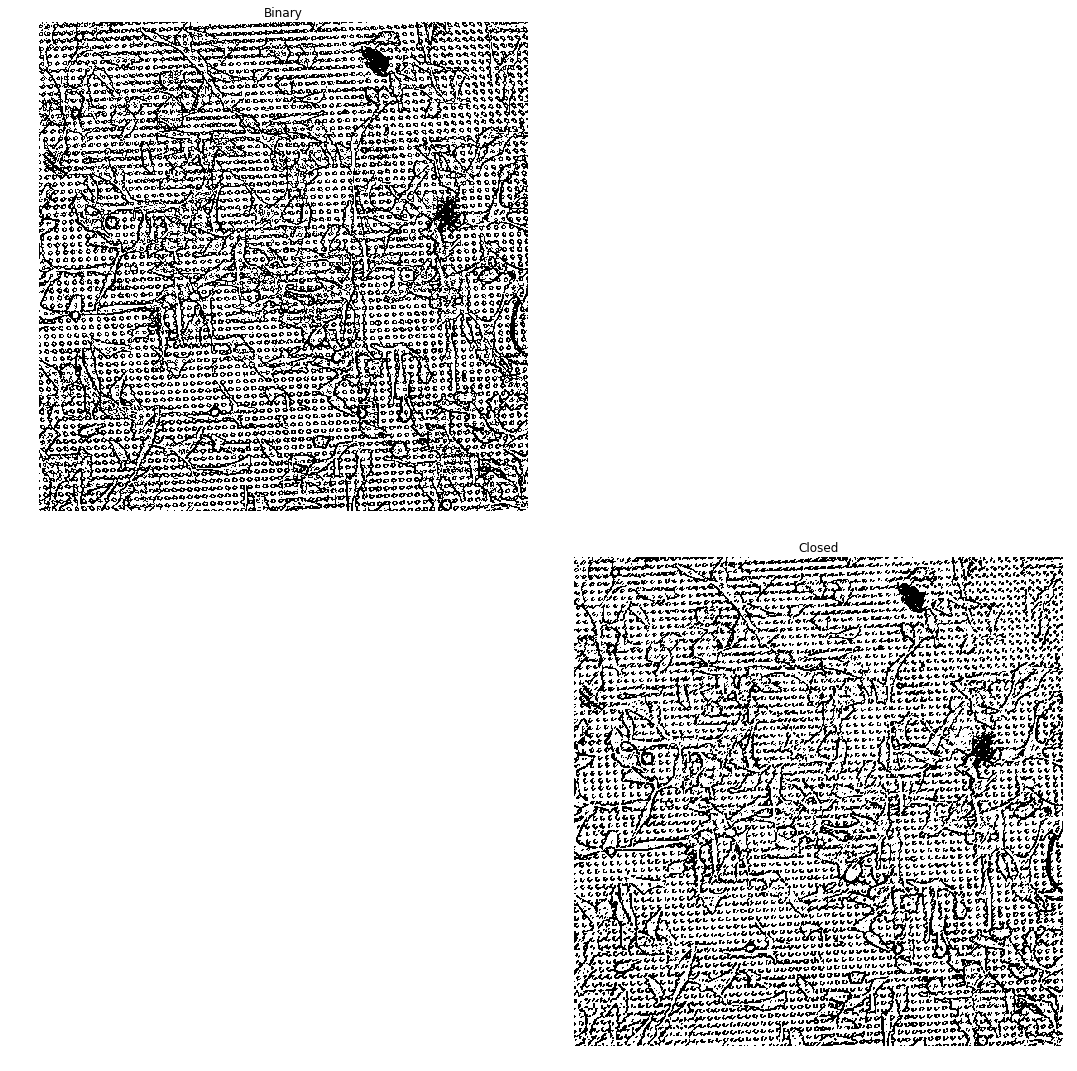

In [6]:
from skimage.morphology  import binary_closing, disk, binary_dilation, remove_small_holes, remove_small_objects
#fill_holes = ndi.morphology.binary_fill_holes(binary, structure=np.ones((15,15))).astype('uint8')

#remove_posts = morphology.remove_small_objects(binary, 85)
#remove_posts = morphology.remove_small_holes(remove_posts, 85)
#remove_posts = remove_posts.astype(np.uint8)

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(2,2))
closed = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations = 2)


fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
ax = axes.ravel()

ax[0].imshow(binary, cmap=plt.cm.gray, interpolation='nearest')
ax[0].set_title('Binary')
#ax[1].imshow(fill_holes, cmap=plt.cm.gray, interpolation='nearest')
#ax[1].set_title('Fill Holes')
#ax[2].imshow(remove_posts, cmap=plt.cm.gray, interpolation='nearest')
#ax[2].set_title('Removed posts')
ax[3].imshow(closed, cmap=plt.cm.gray, interpolation='nearest')
ax[3].set_title('Closed')


for a in ax:
    a.set_axis_off()

plt.tight_layout()
plt.show()
#plt.savefig("2_thresh_close.jpg")

In [7]:
def clear_border(image):
    h, w = image.shape
    mask = np.zeros((h + 2, w + 2), np.uint8)
    for i in range(h-1): # Iterate on the lines
        if image[i, 0] == 255:
            cv2.floodFill(image, mask, (0, i), 0)
        if image[i, w-1] == 255:
            cv2.floodFill(image, mask, (w-1, i), 0)
    for i in range(w-1): # Iterate on the columns
        if image[0, i] == 255:
            cv2.floodFill(image, mask, (i, 0), 0)
        if image[h-1, i] == 255:
            cv2.floodFill(image, mask, (i, h-1), 0)
    return image

#### Sure foreground / background determination

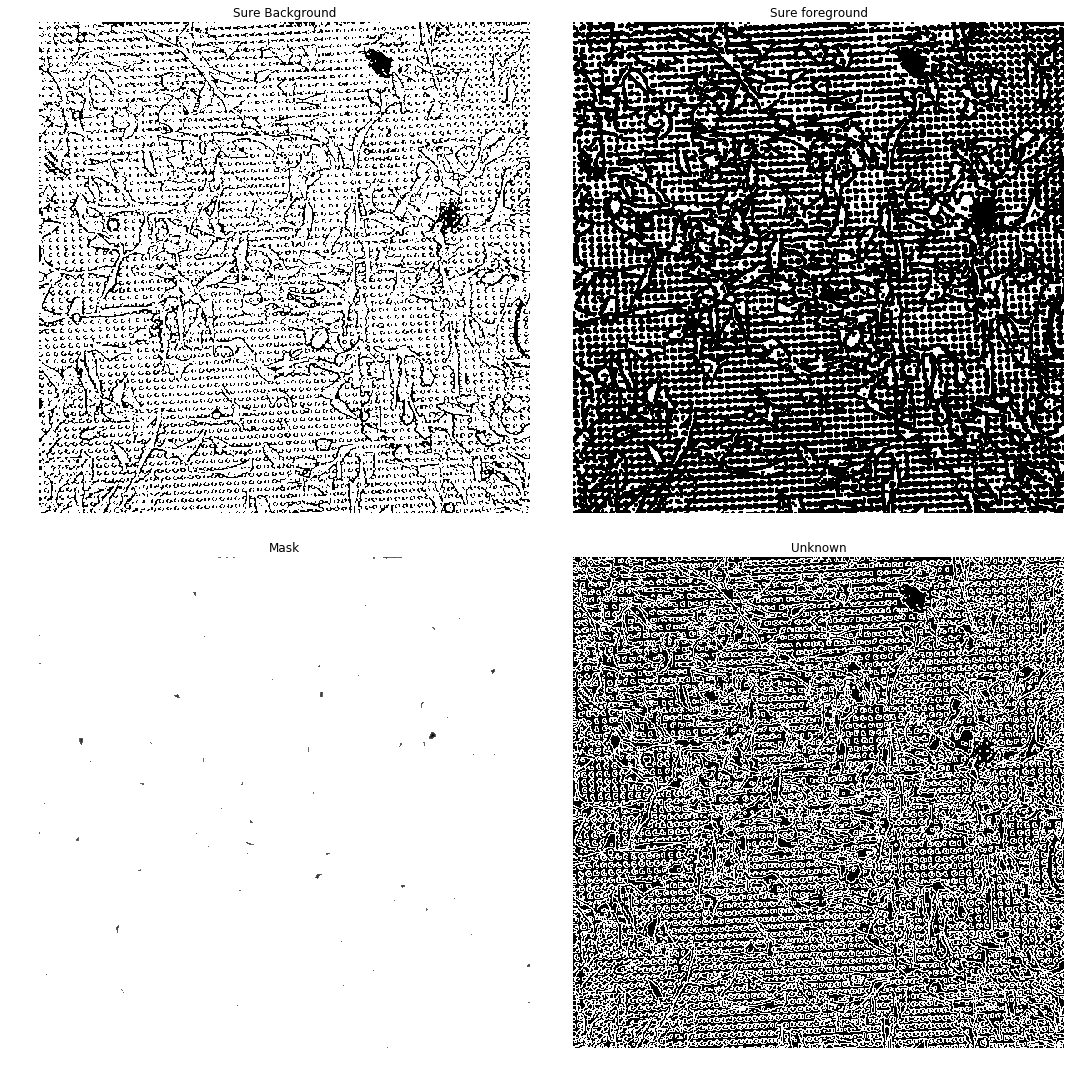

In [8]:
# noise removal
kernel = np.ones((2,2),np.uint8)
#opening = cv2.morphologyEx(closed,cv2.MORPH_OPEN,kernel, iterations = 2)
closing = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations = 2)
# sure background area
#sure_bg = cv2.dilate(opening,kernel,iterations=3)
sure_bg = cv2.dilate(closing,kernel,iterations=1)
# Finding sure foreground area
#dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
dist_transform = cv2.distanceTransform(closing,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.2*dist_transform.max(),255,0)
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

mask = dist_transform.copy()
mask[mask < 8] = 0

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
ax = axes.ravel()

ax[0].imshow(sure_bg, cmap=plt.cm.gray, interpolation='nearest')
ax[0].set_title('Sure Background')
ax[1].imshow(sure_fg, cmap=plt.cm.gray, interpolation='nearest')
ax[1].set_title('Sure foreground')
ax[2].imshow(-mask, cmap=plt.cm.gray, interpolation='nearest')
ax[2].set_title('Mask')
ax[3].imshow(unknown, cmap=plt.cm.gray, interpolation='nearest')
ax[3].set_title('Unknown')

for a in ax:
    a.set_axis_off()

plt.tight_layout()
plt.show()

#### Label markers

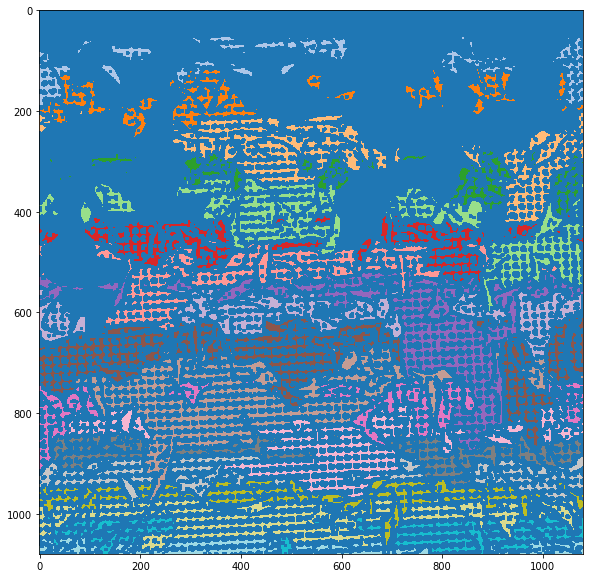

In [9]:
# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
#markers = markers+1

# Now, mark the region of unknown with zero
#markers[unknown>0] = 0

fig = plt.figure(figsize=(15,10))
plt.imshow(markers, cmap=plt.cm.tab20)

#### Run the watershed algorithm

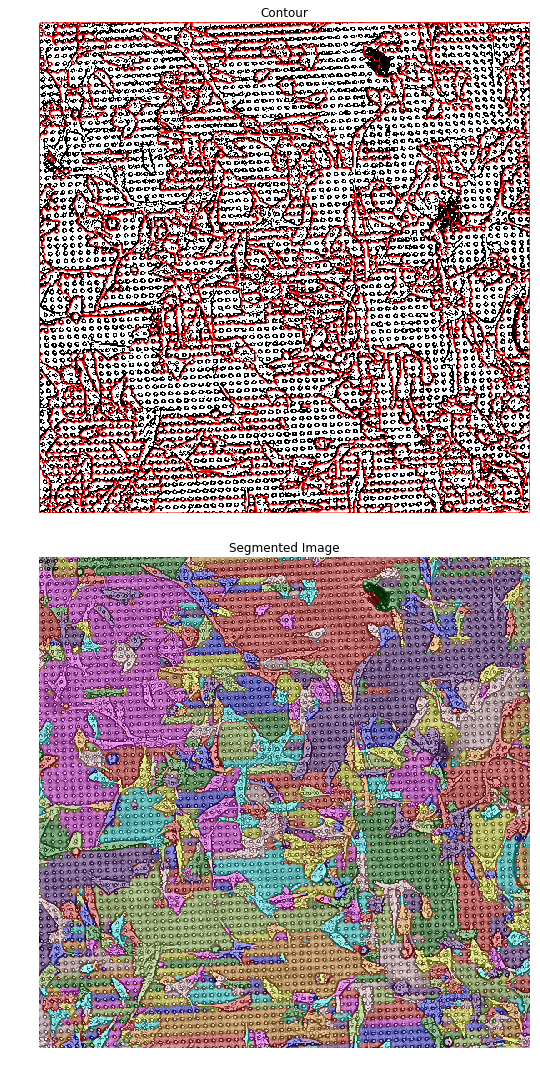

In [10]:
threeChannels = cv2.cvtColor(binary, cv2.COLOR_GRAY2BGR)
segmented = cv2.watershed(threeChannels.astype('uint8'), markers)

# Color the labels sections for display
image_label_overlay = label2rgb(segmented, image=img_adapteq, bg_label=1)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))
ax = axes.ravel()

ax[0].imshow(binary, cmap=plt.cm.gray, interpolation='nearest')
ax[0].contour(segmented, [0.5], linewidths=1, colors='r')
ax[0].set_title('Contour')
ax[1].imshow(image_label_overlay)
ax[1].set_title('Segmented Image')

for a in ax:
    a.set_axis_off()

    
plt.tight_layout()
plt.show()

#### Extract the region properties

Note that label 1 is attributed to the background in the code above

In [11]:
reg = regionprops(segmented, intensity_image=image_file)[1:]
columns= ['Label', 'Area', 'Eccentricity', 'Circularity', 'Bbox Area', 'Bbox', 'Centroid', 'Image', 'Long Axis', 'Short Axis']
df = pd.DataFrame(columns=columns, dtype=np.float64)
df = df.append([{'Label':i.label, 'Area':i.area, 'Eccentricity':i.eccentricity, 'Circularity':(4 * np.pi * i.area / (i.perimeter**2)), 'Bbox Area':i.bbox_area, 'Bbox':i.bbox, 'Centroid':i.centroid, 'Image':i.intensity_image, 'Long Axis':i.major_axis_length, 'Short Axis':i.minor_axis_length} for i in reg])
df.head(5)

/Users/carolinemccue/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning:

divide by zero encountered in double_scalars



Label    Area  Eccentricity  Circularity  Bbox Area               Bbox  \
0    2.0   190.0      0.851285     0.636457  1166400.0    (1, 41, 13, 64)   
1    3.0   208.0      0.930428     0.450768  1166400.0    (1, 60, 13, 91)   
2    4.0  7960.0      0.984659     0.194621  1166400.0   (1, 85, 52, 327)   
3    5.0    10.0      0.791741     1.865648  1166400.0   (1, 333, 5, 336)   
4    6.0  2332.0      0.996862     0.145940  1166400.0  (1, 336, 26, 530)   

                                  Centroid  \
0  (5.5473684210526315, 51.57368421052632)   
1   (4.769230769230769, 74.07211538461539)   
2  (18.62286432160804, 205.34849246231155)   
3                             (2.3, 334.2)   
4    (7.194253859348199, 418.897512864494)   

                                               Image   Long Axis  Short Axis  
0  [[158, 162, 158, 161, 159, 161, 158, 159, 160,...   22.146104   11.620126  
1  [[159, 158, 157, 159, 157, 159, 159, 162, 164,...   29.320357   10.745152  
2  [[0, 0, 175, 179, 172, 161, 159, 162, 161, 162...  262.860024   45.866653  
3  [[149, 141, 153], [146, 137, 155], [0, 143, 15...    4.541385    2.774134  
4  [[0, 161, 164, 171, 169, 160, 157, 161, 159, 1...  217.236095   17.194939

In [12]:
reg = [region for region in reg if (region.area) > 250]

#### Display labeled region bounding boxes and labels

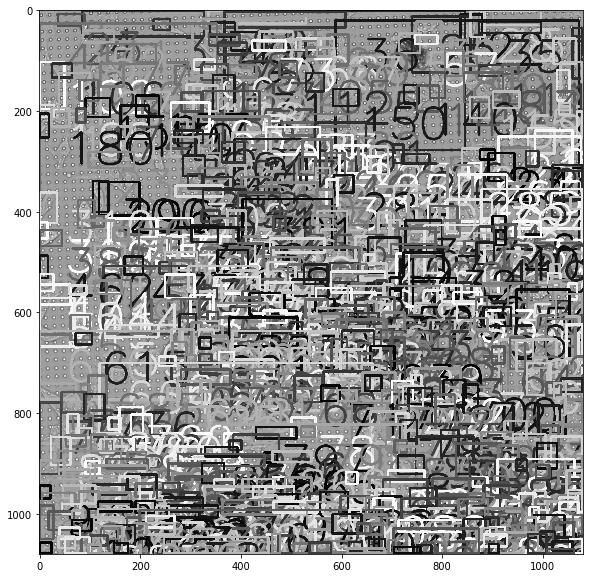

In [13]:
boxed_regions = image_file.copy()

# Iterate over all non-background labels
for region in reg:
    (min_row, min_col, max_row, max_col) = region.bbox
    color = np.uint8(np.random.randint(0, 255, 3)).tolist()
    cv2.rectangle(boxed_regions, (min_col,min_row), (max_col,max_row), color, 3)
    cv2.putText(boxed_regions,'%d'%region.label,(min_col+50, min_row+100), cv2.FONT_HERSHEY_SIMPLEX, 3, color, 3, cv2.LINE_AA)
    
fig = plt.figure(figsize=(15,10))
plt.imshow(boxed_regions, cmap=plt.cm.gray)

(239.0, 959.0087183958152, 959.0087183958152)

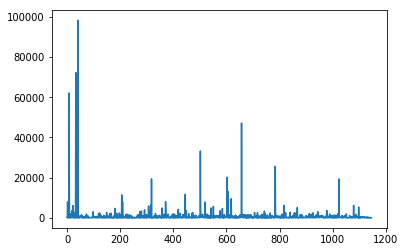

In [14]:
df['Area'].plot()
df['Area'].median(), df['Area'].mean(), df['Area'].mean()

550 cells were detected and segmented
201 cells with selected criteria


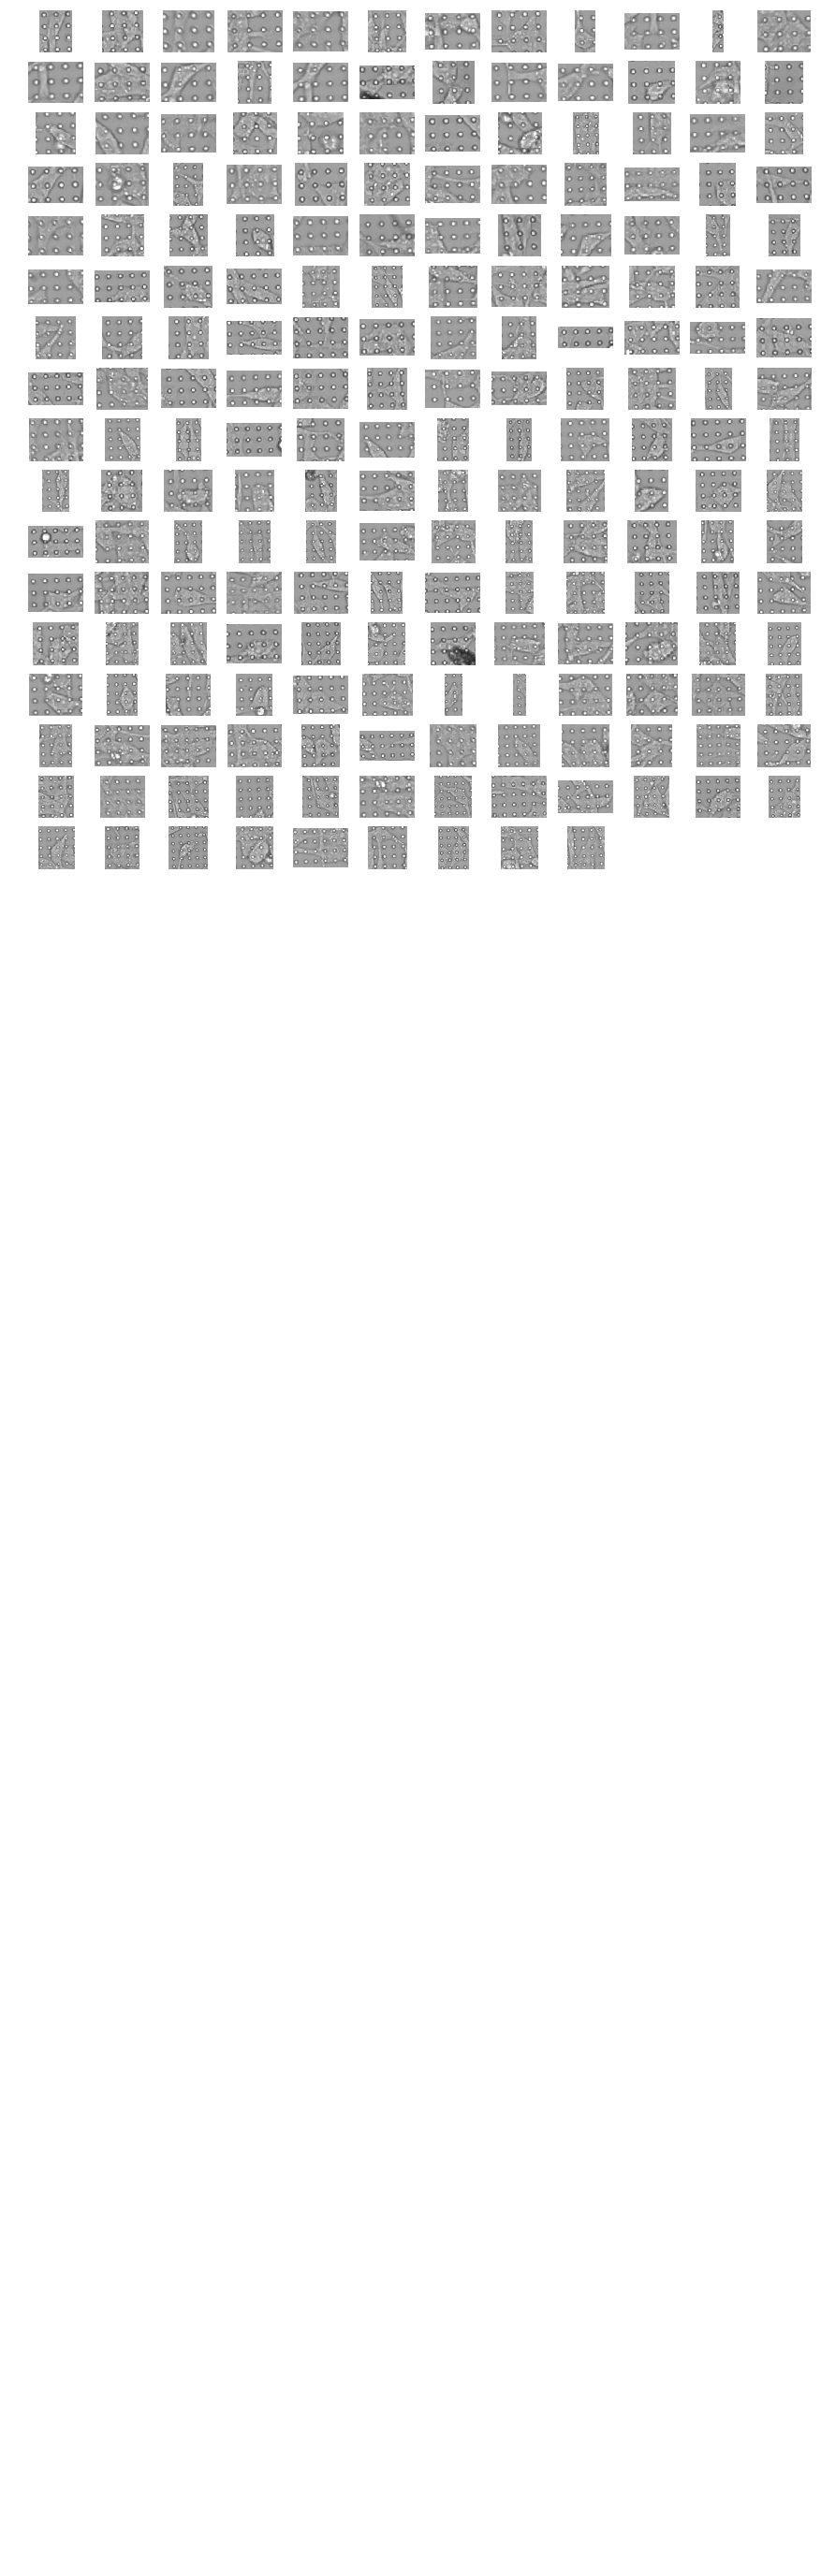

In [45]:
# Display parameters
org_img = image_file # Intensity image
border = 25 # Additional pixels to display on each side of the bounding box
ecc_cutoff = 0.5 # circularity cuttoff, removes background circles
ecc_cutoff_upper = 0.95
area_cutoff_upper = 1.5*df.Area.mean() # Area cuttoff, removes misidentified shapes (for instance half-droplets)
area_cutoff_lower = 2*df.Area.median()
max_col = org_img.shape[1]
max_row = org_img.shape[0]

n_img = len(reg)
print("{} cells were detected and segmented".format(n_img))
n_col = 50
n_rows = n_img // n_col + 1

reg.sort(key=lambda x: x.area)
reg_clean = [region for region in reg if (region.area) > area_cutoff_lower and (region.area) < area_cutoff_upper and region.eccentricity > ecc_cutoff and region.eccentricity < ecc_cutoff_upper]

print("{} cells with selected criteria".format(len(reg_clean), area_cutoff_lower, area_cutoff_upper))

fig, ax = plt.subplots(n_col, n_rows)
axes = ax.ravel()

for i, region in enumerate(reg_clean):
    (min_row, min_col, max_row, max_col) = region.bbox
    drop_image = org_img[np.max([min_row-border,0]):np.min([max_row+border,max_row]),np.max([min_col-border,0]):np.min([max_col+border,max_col])]
    contrast_stretch = exposure.rescale_intensity(drop_image, in_range=(0,255))
    axes[i].imshow(contrast_stretch, cmap=plt.cm.gray, interpolation='nearest', vmin=0, vmax=255)
    axes[i].axis('off')
    
for i in range(n_col*n_rows - len(reg_clean)):
    axes[-(i+1)].axis('off')
    
fig.set_size_inches(15, 50)

In [20]:
import pickle

img_list = []
area_list = []
for region in reg_clean:
        (min_row, min_col, max_row, max_col) = region.bbox
        drop_image = org_img[np.max([min_row-border,0]):np.min([max_row+border,max_row]),np.max([min_col-border,0]):np.min([max_col+border,max_col])]
        contrast_stretch = exposure.rescale_intensity(drop_image, in_range=(0,255))
        img_list.append(contrast_stretch)
        area_list = df['Area'].tolist()
        
        out_directory = image_file.split('.')[0]

        if not os.path.exists(out_directory):
            os.mkdir(out_directory)

        name = os.path.join(out_directory, os.path.basename(image_file).split('.')[0] + '_cell_' + str(i) + '.jpg')
        
        cellarea = {name[i] : area_list[i] for i in range(len(name))}
        
        #ziparea = zip(img_list, area_list)
        #cellarea = dict(zip(img_list, area_list))
        
with open(os.path.join(out_directory, os.path.basename(image_file).split('.')[0] + '.pkl'), 'wb') as f:
    f.write(pickle.dumps(cellarea))
    

AttributeError: 'numpy.ndarray' object has no attribute 'split'

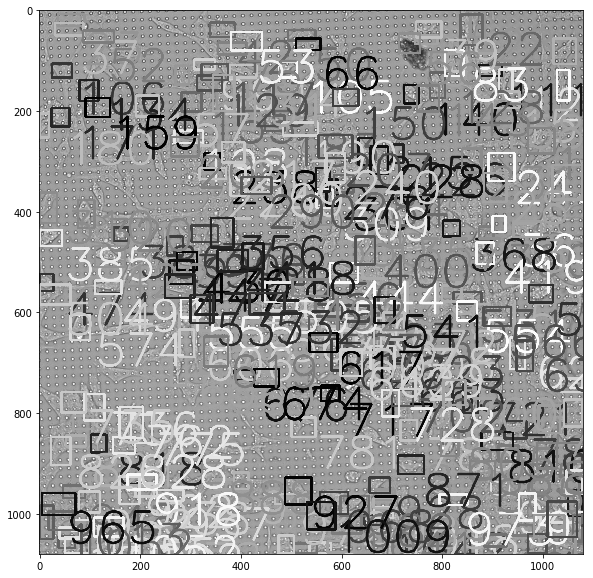

In [46]:
boxed_regions = image_file.copy()
for region in reg_clean:
    (min_row, min_col, max_row, max_col) = region.bbox
    color = np.uint8(np.random.randint(0, 255, 3)).tolist()
    cv2.rectangle(boxed_regions, (min_col,min_row), (max_col,max_row), color, 3)
    cv2.putText(boxed_regions,'%d'%region.label,(min_col+50, min_row+100), cv2.FONT_HERSHEY_SIMPLEX, 3, color, 3, cv2.LINE_AA)
    
fig = plt.figure(figsize=(15,10))
plt.imshow(boxed_regions, cmap=plt.cm.gray)

In [47]:
columns= ['Label', 'Area', 'Eccentricity', 'Circularity', 'Bbox Area', 'Bbox', 'Centroid', 'Image', 'Long Axis', 'Short Axis']
df2 = pd.DataFrame(columns=columns, dtype=np.float64)
df2 = df2.append([{'Label':i.label, 'Area':i.area, 'Eccentricity':i.eccentricity, 'Circularity':(4 * np.pi * i.area / (i.perimeter**2)), 'Bbox Area':i.bbox_area, 'Bbox':i.bbox, 'Centroid':i.centroid, 'Image':i.intensity_image, 'Long Axis':i.major_axis_length, 'Short Axis':i.minor_axis_length} for i in reg_clean])
df2.tail(5)

Label    Area  Eccentricity  Circularity  Bbox Area  \
196  532.0  1412.0      0.846777     0.352434  1166400.0   
197  700.0  1424.0      0.695058     0.404831  1166400.0   
198  131.0  1426.0      0.909957     0.347212  1166400.0   
199  537.0  1431.0      0.775055     0.417849  1166400.0   
200  619.0  1431.0      0.641775     0.424311  1166400.0   

                     Bbox                                 Centroid  \
196  (561, 417, 604, 487)   (581.0949008498584, 456.6083569405099)   
197  (734, 803, 784, 846)    (758.2794943820224, 823.872893258427)   
198  (129, 345, 200, 388)  (165.73702664796633, 365.0427769985975)   
199  (565, 300, 621, 346)  (590.6093640810622, 322.43186582809227)   
200  (648, 327, 707, 375)  (674.4248777078966, 349.80153738644304)   

                                                 Image  Long Axis  Short Axis  
196  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  61.303804   32.610398  
197  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 158, 0, 0, 0, 0, ...  52.837740   37.987900  
198  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  69.834951   28.960727  
199  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  58.788633   37.148162  
200  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  51.481770   39.480995

In [60]:
areaum5 = df2['Area'] / 1.5503 ** 2
areaum5.mean(), areaum5.std()

(360.0513335319122, 111.46257959580475)

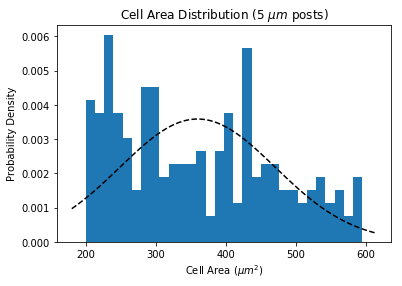

In [61]:
num_bins = 30
mu = areaum5.mean()
std = areaum5.std()
fig, ax = plt.subplots()
plt.hist(areaum5, num_bins, density = 1)

mu, std = norm.fit(areaum5)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)

plt.plot(x, p, '--', color = 'black')
plt.xlabel("Cell Area ($\mu m^2$)")
plt.ylabel("Probability Density")
plt.title("Cell Area Distribution (5 $\mu m$ posts)")
plt.show ()

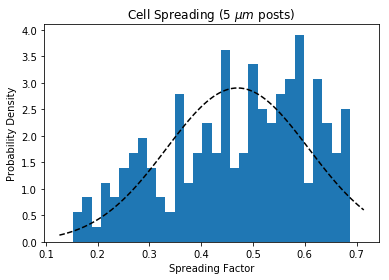

In [62]:
spreading_factor5 = 1 - (df2['Short Axis'] / df2['Long Axis'])

num_bins = 30
muS = spreading_factor5.mean()
stdS = spreading_factor5.std()
fig, ax = plt.subplots()
plt.hist(spreading_factor5, num_bins, density = 1)

muS, stdS = norm.fit(spreading_factor5)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, muS, stdS)

plt.plot(x, p, '--', color = 'black')
plt.xlabel("Spreading Factor")
plt.ylabel("Probability Density")
plt.title("Cell Spreading (5 $\mu m$ posts)")
plt.show ()

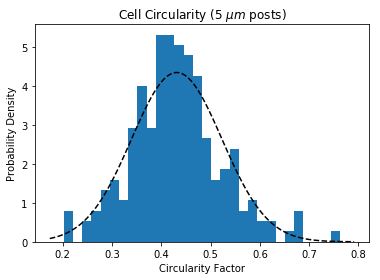

In [63]:
circularity5=df2['Circularity']

num_bins = 30
muC = circularity5.mean()
stdC = circularity5.std()
fig, ax = plt.subplots()
plt.hist(circularity5, num_bins, density = 1)

muC, stdC = norm.fit(circularity5)
xmin, xmax = plt.xlim()
xC = np.linspace(xmin, xmax, 100)
pC = norm.pdf(xC, muC, stdC)

plt.plot(xC, pC, '--', color = 'black')
plt.xlabel("Circularity Factor")
plt.ylabel("Probability Density")
plt.title("Cell Circularity (5 $\mu m$ posts)")
plt.show ()

In [64]:
%store areaum5
%store spreading_factor5
%store circularity5

Stored 'areaum5' (Series)
Stored 'spreading_factor5' (Series)
Stored 'circularity5' (Series)
